    Ben Christensen
    Math 323
    March 27, 2018

Solve the linear interior point problem. Use these to code the LAD (Least Absolute Deviations) Model.

In [1]:
import numpy as np
from scipy import linalg as la
from scipy.stats import linregress
from matplotlib import pyplot as plt

In [2]:
# Auxiliary Functions ---------------------------------------------------------
def startingPoint(A, b, c):
    """Calculate an initial guess to the solution of the linear program
    min c^T x, Ax = b, x>=0.
    Reference: Nocedal and Wright, p. 410.
    """
    # Calculate x, lam, mu of minimal norm satisfying both
    # the primal and dual constraints.
    B = la.inv(A @ A.T)
    x = A.T @ B @ b
    lam = B @ A @ c
    mu = c - (A.T @ lam)

    # Perturb x and s so they are nonnegative.
    dx = max((-3./2)*x.min(), 0)
    dmu = max((-3./2)*mu.min(), 0)
    x += dx*np.ones_like(x)
    mu += dmu*np.ones_like(mu)

    # Perturb x and mu so they are not too small and not too dissimilar.
    dx = .5*(x*mu).sum()/mu.sum()
    dmu = .5*(x*mu).sum()/x.sum()
    x += dx*np.ones_like(x)
    mu += dmu*np.ones_like(mu)

    return x, lam, mu

# Use this linear program generator to test your interior point method.
def randomLP(m):
    """Generate a 'square' linear program min c^T x s.t. Ax = b, x>=0.
    First generate m feasible constraints, then add slack variables.
    Parameters:
        m -- positive integer: the number of desired constraints
             and the dimension of space in which to optimize.
    Returns:
        A -- array of shape (m,n).
        b -- array of shape (m,).
        c -- array of shape (n,).
        x -- the solution to the LP.
    """
    n = m
    A = np.random.random((m,n))*20 - 10
    A[A[:,-1]<0] *= -1
    x = np.random.random(n)*10
    b = A.dot(x)
    c = A.sum(axis=0)/float(n)
    return A, b, -c, x

# This random linear program generator is more general than the first.
def randomLP2(m,n):
    """Generate a linear program min c^T x s.t. Ax = b, x>=0.
    First generate m feasible constraints, then add
    slack variables to convert it into the above form.
    Parameters:
        m -- positive integer >= n, number of desired constraints
        n -- dimension of space in which to optimize
    Returns:
        A -- array of shape (m,n+m)
        b -- array of shape (m,)
        c -- array of shape (n+m,), with m trailing 0s
        v -- the solution to the LP
    """
    A = np.random.random((m,n))*20 - 10
    A[A[:,-1]<0] *= -1
    v = np.random.random(n)*10
    k = n
    b = np.zeros(m)
    b[:k] = A[:k,:].dot(v)
    b[k:] = A[k:,:].dot(v) + np.random.random(m-k)*10
    c = np.zeros(n+m)
    c[:n] = A[:k,:].sum(axis=0)/k
    A = np.hstack((A, np.eye(m)))
    return A, b, -c, v


# Problems --------------------------------------------------------------------
def interiorPoint(A, b, c, niter=20, tol=1e-16, verbose=False):
    """Solve the linear program min c^T x, Ax = b, x>=0
    using an Interior Point method.

    Parameters:
        A ((m,n) ndarray): Equality constraint matrix with full row rank.
        b ((m, ) ndarray): Equality constraint vector.
        c ((n, ) ndarray): Linear objective function coefficients.
        niter (int > 0): The maximum number of iterations to execute.
        tol (float > 0): The convergence tolerance.

    Returns:
        x ((n, ) ndarray): The optimal point.
        val (float): The minimum value of the objective function.
    """
    #Initialize important variables
    m,n = A.shape
    #Compute the first two block rows of DF only once (for use in searchDirection):
    stable = np.vstack((np.hstack((np.zeros((n,n)), A.T, np.eye(n))), np.hstack((A, np.zeros((m,m)), np.zeros((m,n))))))

    #Helper functions defined before algorithm is implemented
    F = lambda x, lamb, mu: np.concatenate((A.T @ lamb + mu - c, A@x - b, np.diag(mu) @ x))

    def searchDirection(x, lamb, mu):
        """Compute the search direction using F and DF

        Parameters:
            x ((n, ) ndarray): input vector
            lamb ((m, ) ndarray): penalty for breaking equality constraint
            mu ((n, ) ndarray): penalty for breaking inequality constraing

        Returns:
            ((2n+m, ) ndarray): (∆x.T, ∆lamb.T, ∆mu.T)
        """
        D_F = np.vstack((stable, np.hstack((np.diag(mu), np.zeros((n,m)), np.diag(x)))))
        #Only compute F(x, lamb, mu) once
        F_ = F(x, lamb, mu)
        return la.lu_solve(la.lu_factor(D_F), -F_ + np.insert((np.dot(x, mu) / (10*n))*np.ones(n), 0, np.zeros(n+m)))

    def stepSize(x, lamb, mu, d_x, d_lamb, d_mu):
        #For mu
        mask = d_mu < 0
        alpha = np.min((1, np.min(-mu[mask] / d_mu[mask])))
        #For x
        mask = d_x < 0
        delta = np.min((1, np.min(-x[mask] / d_x[mask])))

        return np.min((1, .95*alpha)), np.min((1, .95*delta))

    #Generate Starting Point
    x, lamb, mu = startingPoint(A, b, c)
    #Begin recursive algorithm
    for i in range(niter):
        if x@mu / n < tol:
            break
        #We need the search direction in multiple places. Calculate it once per iteration.
        direction = searchDirection(x, lamb, mu)
        d_x, d_lamb, d_mu = direction[:n], direction[n:n+m], direction[n+m:]
        alpha, delta = stepSize(x, lamb, mu, d_x, d_lamb, d_mu)
        #Find next x, lambda, mu
        x += delta*d_x
        lamb += alpha*d_lamb
        mu += alpha*d_mu

    return x, c@x

def leastAbsoluteDeviations(filename='/Users/benchristensen/Desktop/ACME Python Labs/Volume2-Student-Materials/InteriorPoint_Linear/simdata.txt'):
    """Generate and show the plot requested in the lab."""
    with open(filename, 'r') as myfile:
        lines = [line for line in myfile]
        x = np.array([float(line.strip().split()[1]) for line in lines])
        y = np.array([float(line.strip().split()[0 ]) for line in lines])

    #Initialize the optimization problem
    b = np.ravel(np.array(list(zip(-y, y))))
    m = len(y)
    n = 1
    c = np.concatenate((np.ones(m), np.zeros(2*m + 2*(n+1))))
    #Initialize A (HARD!)
    A = np.ones((2*m, 3*m + 2*(n+1)))
    A[::2, :m] = np.eye(m)
    A[1::2, :m] = np.eye(m)
    A[::2, m:m+n] = -x.reshape((-1,1))
    A[1::2, m:m+n] = x.reshape((-1,1))
    A[::2, m+n:m+2*n] = x.reshape((-1,1))
    A[1::2, m+n:m+2*n] = -x.reshape((-1,1))
    A[::2, m+2*n] = -1
    A[1::2, m+2*n+1] = -1
    A[:, m+2*n+2:] = -np.eye(2*m, 2*m)
    #Solve and extract solution
    sol = interiorPoint(A, b, c, niter=10)[0]
    beta = sol[m:m+n] - sol[m+n:m+2*n]
    b = sol[m+2*n] - sol[m+2*n+1]
    #Plot Least Absolute Deviations Model
    domain = np.linspace(0,10,200)
    plt.plot(domain, beta*domain + b, label="LAD Model")
    #Plot Linear Regression Model
    slope, intercept = linregress(x, y)[:2]
    plt.plot(domain, domain*slope + intercept, label="Linear Regression")
    plt.scatter(x,y, label="Data")
    plt.legend(loc="upper right")
    plt.title("Comparing the LAD Model with Linear Regression")
    plt.show()



True


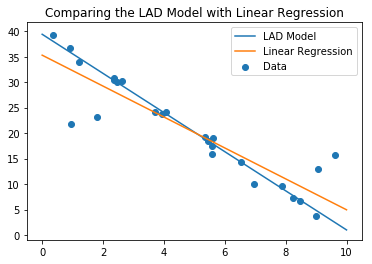

In [3]:
m,n = 7,5
A, b, c, x = randomLP2(m,n)
point, value = interiorPoint(A,b,c)
print(np.allclose(x, point[:n]))
leastAbsoluteDeviations()